# XGBoost

Gradient Boosting tiene como objetivo minimizar el error general del modelo, pero XGBoost, o Extreme Gradient Boosting, va un paso más allá. XGBoost ha revolucionado el método Gradient Boosting (GBM) estándar a través de meticulosa optimización de sistemas y mejoras algorítmicas. Esta optimización refleja la precisión y eficiencia que se observa en la ingeniería, donde cada componente está ajustado para lograr el máximo rendimiento. De manera similar, las funciones avanzadas de XGBoost, como el manejo de datos faltantes y el suministro de capacidades de procesamiento paralelo, representan el énfasis en la eficiencia y la velocidad del Machine Learning.

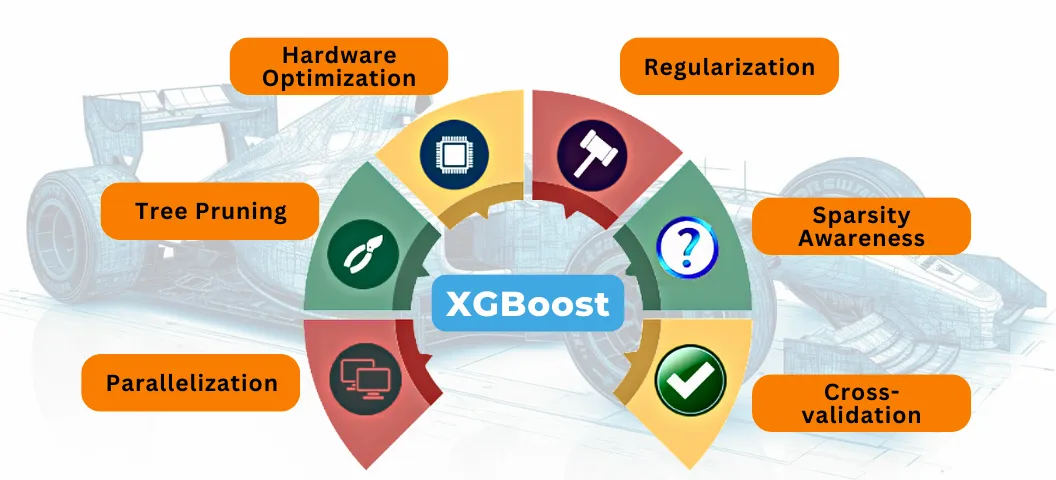

Optimización algorítmica y del sistema en XGBoost:

- **Paralelización:** una de las optimizaciones del sistema de mayor impacto en XGBoost es la paralelización. El GBM tradicional construye árboles de forma secuencial, lo que puede llevar mucho tiempo. XGBoost, sin embargo, paraleliza este proceso, lo que significa que construye varios árboles al mismo tiempo, lo que acelera significativamente el proceso de aprendizaje. Esto se logra reordenando los bucles computacionales en el algoritmo, permitiendo cálculos simultáneos.

- **Poda de árboles:** en el marco de GBM, los árboles se construyen con avidez, lo que significa que siguen creciendo hasta que se cumple un criterio de parada. XGBoost introduce una mejora con un enfoque de "primero en profundidad". Utiliza un parámetro 'max_ Depth' y comienza a podar árboles hacia atrás desde la profundidad máxima, mejorando la eficiencia computacional.

- **Optimización de hardware:** XGBoost está diseñado para utilizar los recursos de hardware de manera más eficiente. Incluye operaciones con reconocimiento de caché y computación "fuera del núcleo", que ayuda a manejar grandes conjuntos de datos que no caben en la memoria. Esta optimización garantiza un mejor rendimiento, especialmente cuando se trata de big data.

- **Regularización:** la regularización es una técnica utilizada para evitar el sobreajuste, donde el modelo funciona bien con datos de entrenamiento pero mal con datos invisibles. XGBoost incluye regularización L1 (LASSO) y L2 (Ridge). Estos términos de regularización añaden penalizaciones para modelos más complejos, ayudando a mantenerlos más simples y generalizables.

- **Conciencia de escasez:** "datos escasos" se refiere a conjuntos de datos con muchos elementos faltantes o de valor cero. XGBoost es eficiente en el manejo de datos escasos. Puede identificar y aprender automáticamente la mejor manera de manejar los valores faltantes, mejorando el rendimiento en conjuntos de datos con muchos datos faltantes.

- **Validación cruzada:** XGBoost tiene un método de validación cruzada incorporado, que elimina la necesidad de implementación manual. Esta característica ayuda a determinar la cantidad de iteraciones de refuerzo necesarias, minimizando los riesgos de underfitting y overfitting..

XGBoost ha demostrado constantemente un rendimiento y una eficiencia superiores en comparación con otros algoritmos de Machine Learning. Su uso de regularización y modelos basados en árboles ha contribuido significativamente a su solidez y transparencia. A diferencia de otros modelos complejos de caja negra, como las redes neuronales, el marco del árbol de decisiones de XGBoost lo hace más interpretable y más fácil de entender.

# Ejemplo de Regresión

El conjunto de datos contienen transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeos.

Contiene solo variables de entrada numéricas que son el resultado de una transformación PCA. Desafortunadamente, debido a problemas de confidencialidad, no podemos proporcionar las características originales ni más información general sobre los datos. Las características V1, V2, … V28 son los principales componentes obtenidos con PCA, las únicas características que no han sido transformadas con PCA son 'Tiempo' y 'Cantidad'. La característica 'Tiempo' contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. La función 'Cantidad' es la cantidad de la transacción, esta función se puede utilizar para el aprendizaje sensible a los costos dependiente del ejemplo. Feature 'Class' es la variable de respuesta y toma valor 1 en caso de fraude y 0 en caso contrario.


## Importar librerias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import copy

from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
#Metricas
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Funciones auxiliares

In [2]:
# Construcción de un pipeline para los atributos numéricos
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('rbst_scaler', RobustScaler()),
    ])

In [3]:
# Transormador para codificar únicamente las columnas categoricas y devolver un df
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse=False)
        self._columns = None
    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh, 
                                columns=self._columns, 
                                index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)

In [4]:
# Transformador que prepara todo el conjunto de datos llamando pipelines y transformadores personalizados
class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._full_pipeline = None
        self._columns = None
    def fit(self, X, y=None):
        num_attribs = list(X.select_dtypes(exclude=['object']))
        cat_attribs = list(X.select_dtypes(include=['object']))
        self._full_pipeline = ColumnTransformer([
                ("num", num_pipeline, num_attribs),
                ("cat", CustomOneHotEncoder(), cat_attribs),
        ])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep, 
                            columns=self._columns, 
                            index=X_copy.index)

## Cargar datos

In [5]:
dataset = pd.read_excel('SCFP2009panel.xlsx')

## Preparamos la variable de predicción

In [6]:
# Promedio SP500 durante el 2007 y 2009
Average_SP500_2007=1478
Average_SP500_2009=948

# Tolerancia al riesgo en 2007
dataset['RiskFree07']= dataset['LIQ07'] + dataset['CDS07'] + dataset['SAVBND07'] + dataset['CASHLI07']
dataset['Risky07'] = dataset['NMMF07'] + dataset['STOCKS07'] + dataset['BOND07'] 
dataset['RT07'] = dataset['Risky07']/(dataset['Risky07']+dataset['RiskFree07'])

# Tolerancia al riesgo en 2009
dataset['RiskFree09']= dataset['LIQ09'] + dataset['CDS09'] + dataset['SAVBND09'] + dataset['CASHLI09']
dataset['Risky09'] = dataset['NMMF09'] + dataset['STOCKS09'] + dataset['BOND09'] 
dataset['RT09'] = dataset['Risky09']/(dataset['Risky09']+dataset['RiskFree09'])*\
                (Average_SP500_2009/Average_SP500_2007)

Calculemos el cambio porcentual en la tolerancia al riesgo entre 2007 y 2009.

In [7]:
dataset2 = copy.deepcopy(dataset)
dataset2['PercentageChange'] = np.abs(dataset2['RT09']/dataset2['RT07']-1)

Comprobando las filas con valores nulos o nan y eliminándolas.

In [8]:
dataset2=dataset2.dropna(axis=0)
dataset2=dataset2[~dataset2.isin([np.nan, np.inf, -np.inf]).any(1)]

En el siguiente paso, elegimos a los inversores inteligentes cuyo cambio en la tolerancia al riesgo entre 2007 y 2009 fue inferior al 10%. El propósito sería predecir la verdadera tolerancia al riesgo de un individuo dadas las características demográficas, financieras y de disposición a asumir riesgos.

In [9]:
dataset3 = copy.deepcopy(dataset2)  
dataset3 = dataset3[dataset3['PercentageChange']<=.1]
dataset3['TrueRiskTolerance'] = (dataset3['RT07'] + dataset3['RT09'])/2

Eliminemos otras etiquetas que podrían no ser necesarias para la predicción.

In [10]:
dataset3.drop(labels=['RT07', 'RT09'], axis=1, inplace=True)
dataset3.drop(labels=['PercentageChange'], axis=1, inplace=True)

## Selección de variables

### Eliminación de variables

Para filtrar aún más las variables, hacemos lo siguiente:

1. Consulte la descripción en el Diccionario de datos (https://www.federalreserve.gov/econres/files/codebk2009p.txt, https://www.federalreserve.gov/econresdata/scf/files/fedstables.macro.txt) y mantengamos sólo las variables que sean intuitivas

La descripción es la siguiente:


- **AGE:** Hay 6 categorías de edad, donde 1 representa menos de 35 años y 6 representa más de 75 años.
- **EDUC:** Hay 4 categorías educativas, donde 1 representa sin escuela secundaria y 4 representa título universitario.
- **MARRIED:** Representa el estado civil. Hay dos categorías donde 1 representa casado y 2 representa soltero.
- **OCCU:** Representa la categoría de ocupación. 1 representa categoría gerencial y 4 representa desempleado.
- **KIDS:** Representa el número de niños.
- **NWCAT:** Representa la categoría de patrimonio neto. Hay 5 categorías, donde 1 representa un patrimonio neto inferior al percentil 25 y 5 representa un patrimonio neto superior al percentil 90.
- **INCCL:** Representa la categoría de ingresos. Hay 5 categorías, donde 1 ingreso menor a 10,000 y 5 representa un patrimonio neto mayor a 100,000
- **RISK:** Representa la disposición a asumir riesgos en una escala de 1 a 4, donde 1 representa el nivel más alto de disposición a asumir riesgos.

2. Mantener sólo los factores intuitivos a partir de 2007 únicamente y eliminar todas las características intermedias y características relacionadas con 2009, ya que las variables de 2007 son las únicas necesarias para predecir la tolerancia al riesgo.

In [11]:
keep_list2 = ['AGE07','EDCL07','MARRIED07','KIDS07','OCCAT107','INCOME07','RISK07',
              'NETWORTH07','TrueRiskTolerance']

drop_list2 = [col for col in dataset3.columns if col not in keep_list2]

dataset3.drop(labels=drop_list2, axis=1, inplace=True)

In [12]:
dataset3.head()

,AGE07,EDCL07,MARRIED07,KIDS07,OCCAT107,INCOME07,RISK07,NETWORTH07,TrueRiskTolerance
60,77,2,1,0,3,3.141680e+04,4,2.152490e+05,0.199511
425,55,4,1,1,2,2.779588e+06,2,4.964759e+07,0.641458
1122,85,4,1,0,2,3.727417e+05,4,5.837768e+07,0.589943
1190,40,2,1,3,1,5.324882e+04,3,2.688929e+05,0.434127
1228,70,2,1,0,2,3.716767e+04,3,2.015066e+06,0.228218


## División de los datos

In [13]:
# dividir el conjunto de datos de validación para el final
Y= dataset3["TrueRiskTolerance"]
X = dataset3.loc[:, dataset3.columns != 'TrueRiskTolerance']
validation_size = 0.2
seed = 3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

## Modelo XGBoost para la regresión

In [14]:
model_XGBR = xgb.XGBRegressor()
model_XGBR.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Predicción

In [15]:
Y_pred = model_XGBR.predict(X_test)

In [16]:
# Error de test del modelo 
# ==============================================================================
rmse_xgbr = mean_squared_error(
            y_true  = Y_test,
            y_pred  = Y_pred,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_xgbr}")


El error (rmse) de test es: 0.09866144476881845


# Ejemplo de clasificación 

El conjunto de datos contienen transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeos.

Contiene solo variables de entrada numéricas que son el resultado de una transformación PCA. Desafortunadamente, debido a problemas de confidencialidad, no podemos proporcionar las características originales ni más información general sobre los datos. Las características V1, V2, … V28 son los principales componentes obtenidos con PCA, las únicas características que no han sido transformadas con PCA son 'Tiempo' y 'Cantidad'. La característica 'Tiempo' contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. La función 'Cantidad' es la cantidad de la transacción, esta función se puede utilizar para el aprendizaje sensible a los costos dependiente del ejemplo. Feature 'Class' es la variable de respuesta y toma valor 1 en caso de fraude y 0 en caso contrario.

In [17]:
dataset = pd.read_csv("creditcard.csv")

## División del conjunto de datos

In [18]:
Y= dataset["Class"]
X = dataset.loc[:, dataset.columns != 'Class']
validation_size = 0.2
seed = 7
X_train, X_test, Y_train, Y_test =train_test_split(X, Y, test_size=validation_size, 
                                                   stratify=dataset["Class"],
                                                   random_state=seed)

## Preparación del conjunto de datos¶

In [19]:
# Instanciamos nuestro transformador personalizado
data_preparer = DataFramePreparer()

In [20]:
# Hacemos el fit con el conjunto de datos general para que adquiera todos los valores posibles
data_preparer.fit(X)

DataFramePreparer()

## Escalado del conjunto de datos

In [21]:
# Transformamos el subconjunto de datos de entrenamiento
X_train_prep = data_preparer.transform(X_train)

In [22]:
# Transformamos el subconjunto de datos de validacion
X_test_prep = data_preparer.transform(X_test)

## Modelo XGBoost para la clasificación

In [23]:
model_XGBC = xgb.XGBClassifier()
model_XGBC.fit(X_train_prep, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [24]:
# Accuracy de test del modelo 

Y_pred = model_XGBC.predict(X=X_test_prep)
print(accuracy_score(Y_test, Y_pred))

0.9995962220427653
